# Spotify Track Analytics Popularity Prediction: ML Models

### Introduction

This notebook extends the Spotify track exploration work by building end-to-end ML workflows that predict a song's popularity score from its audio features and metadata. We will establish a clean dataset, prepare modeling pipelines, and compare baseline algorithms to understand which inputs drive popularity predictions.

---

For establishing furhter ML modeling, it is necessary to import libraries

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

As the first step the cleaned in [previous notebook](https://github.com/YShutko/CI_spotify_track_analysis/blob/2972bbfa3227c3ab665618cfcf3cae74f5215dbe/notebooks/Spotify_track_analysis.ipynb) dataset.

In [50]:
# Load dataset
df = pd.read_csv('../data/spotify_cleaned_data.csv')  # Adjust path as needed
df.head ()

,artists,album_name,track_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration_min
0,gen hoshino,comedy,comedy,73,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,3.844433
1,ben woodward,ghost (acoustic),ghost acoustic,55,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2.493500
2,ingrid michaelson and zayn,to begin again,to begin again,57,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,3.513767
3,kina grannis,crazy rich asians (original motion picture sou...,can't help falling in love,71,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,3.365550
4,chord overstreet,hold on,hold on,82,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,3.314217


---

### 1. Linear Regression

#### Introduction

In this part of the project, we build a Linear Regression model to predict a track’s popularity based on its audio features (danceability, energy, loudness, valence, etc.) and engineered features (mood, intensity). Linear Regression helps us understand how each feature influences popularity and serves as a simple baseline model. Before training, we preprocess the data using scaling and one-hot encoding to ensure all features are on comparable scales and properly formatted for the model. This baseline evaluation provides a reference point for comparing more advanced machine learning models later in the project.

#### Model building

In the following steps feature engeneering is performed. 

Linear regression can only learn straight-line relationships.
But many musical characteristics are nonlinear and interact with each other.
By multiplying two features, we allow the model to learn interaction patterns that linear regression cannot capture naturally.

Energy * loudness helps the model understand: "How intense, powerful, and high-impact the song feels."
This is strongly related to genre and mood, which correlate with popularity and listener engagement.
Without this feature:
The model only sees energy and loudness independently
→ losing important relationships
→ decreasing predictive power

"Mood" is not directly in the dataset, but it is one of the strongest predictors of human music preference.
These 3 features measure:
* Danceability → how rhythmically engaging
* Energy → how active or intense
* Valence → positivity/happiness
Averaging them gives a general emotional / vibe score.
What it gives the model:
* A single, compact representation of “how the song feels”
* Helps cluster songs by vibe
* Helps regression capture patterns like:
* happy energetic songs tend to be more popular
* sad low-energy songs tend to rank differently

Why linear regression benefits:
This creates a latent feature (a hidden variable) that captures something meaningful which raw variables alone cannot represent.

Spotify dataset stores "explicit" as 0/1 integers, which machine learning treats as numeric.
But it is not numeric — it’s categorical (yes/no).

If not converted:
* The model will treat explicit = 1 as “higher” than explicit = 0
* It will try to fit a line like: popularity = ... + 3.7 * explicit
* This is incorrect, because explicitness is not a quantity

After converting to Boolean:
* True / False becomes a category
* It will be one-hot encoded correctly (explicit_True, explicit_False)

This avoids incorrect numerical influence and improves model interpretation.

In [51]:
# Interaction: energy * loudness (how intense & loud a track feels)
df["energy_loudness"] = df["energy"] * df["loudness"]

# Simple "mood" score: combination of danceability, energy, valence
df["mood"] = (df["danceability"] + df["energy"] + df["valence"]) / 3

#explicit is not boolean already, convert it
df["explicit"] = df["explicit"].astype(bool)

Next step is to select the prediction target and features.
`popularity` is used as the target variable `y`. `X` is builded from sound characteristics (tempo, danceability, energy, etc.), boolean/context flags (explicit, key, mode), and any engineered aggregates. 

In [52]:
target = "popularity"

numeric_features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
    # engineered:
    "duration_min",
    "energy_loudness",
    "mood",
]

categorical_features = [
    "explicit",      # True/False
    "track_genre",   # 125 genres, will be one-hot encoded
]

X = df[numeric_features + categorical_features]
y = df[target]

Preprocessing: Scaling + One-Hot Encoding

StandardScaler
Scales all numeric features so they have mean = 0 and standard deviation = 1.
This prevents large-valued columns (e.g., duration_ms) from dominating the model.

OneHotEncoder
Converts categorical features (e.g., track_genre, explicit) into numeric vectors.
handle_unknown="ignore" prevents errors if unseen categories appear in test data.

ColumnTransformer
Applies scaling to numeric columns and one-hot encoding to categorical columns in a single unified preprocessing step.
Ensures consistent, leak-free preprocessing inside the ML pipeline.

In [53]:
# Preprocessing: scaling + one-hot encoding
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Pipeline: Preprocessing → Linear Regression

The Pipeline combines all steps into one model:

First, it applies preprocessing
(scaling numeric features + one-hot encoding categorical features)

Then, it runs LinearRegression on the transformed data.

This ensures the same preprocessing is applied during both training and prediction, preventing data leakage and keeping the workflow clean and reproducible.

In [54]:

# Build pipeline: preprocessing → linear regression
model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
    ]
)


Train/Test Split
train_test_split divides the dataset into two parts:
* Training set (80%) → used to fit the model
* Test set (20%) → used to evaluate how well the model generalizes

random_state=42 ensures the split is reproducible every time you run the code.

In [55]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


And fit he model

In [56]:

# Fit model
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Model Evaluation
After predicting values on the test set (y_pred), we calculate key regression metrics:
* MAE (Mean Absolute Error): Average absolute difference between predicted and actual popularity.
* RMSE (Root Mean Squared Error): Penalizes large errors more strongly; shows overall prediction error.
* R² Score: Measures how much variance in popularity the model explains (1 = perfect fit, 0 = no predictive power).

These metrics tell us how well the linear regression model performs on unseen data.

In [57]:
# Evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression results:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R^2  : {r2:.3f}")

Linear Regression results:
MAE  : 14.174
RMSE : 19.321
R^2  : 0.252


* R² = 0.25 means:Weak model fit
Linear relationships between features and target are limited
Model captures only basic trends (e.g., louder = slightly more popular)

* MAE ≈ 14 → Not acceptable for predictive tasks:
A good model should have MAE < 8 for Spotify popularity
Industry models often get MAE ≈ 6–10 by adding external metadata

* RMSE ≈ 19 → High variance in the errors:
The model makes some very large mistakes
Linear Regression underfits the data
Popularity is nonlinear + influenced by many missing factors

Numeric feature importance

In [ ]:
numeric_importance = importance_df[
    ~importance_df["feature"].str.contains("track_genre")
]

numeric_importance.head(20)



,feature,coefficient,abs_importance
15,cat__explicit_False,-1.406254,1.406254
16,cat__explicit_True,1.406254,1.406254
0,num__danceability,1.222554,1.222554
9,num__valence,-1.153174,1.153174
6,num__acousticness,-0.566002,0.566002
4,num__mode,-0.499868,0.499868
1,num__energy,-0.439317,0.439317
5,num__speechiness,-0.434526,0.434526
14,num__mood,-0.396467,0.396467
13,num__energy_loudness,0.375180,0.375180


Top Predictors:
* explicit (True/False) → explicit content has the strongest effect among numeric/categorical non-genre features.
    * Negative/positive signs cancel because both dummy columns appear; importance is the magnitude.
* danceability → more danceable tracks tend to be more popular.
* valence → happier, more positive-sounding songs tend to be more popular.
* acousticness (negative) → high acousticness lowers predicted popularity.
* mode and energy → moderately contribute; higher energy slightly increases popularity.
* speechiness (negative) → tracks with more spoken content (rap, spoken word) tend to score lower.
* mood → higher combined mood (danceability + energy + valence) improves popularity.
* energy_loudness → intensity contributes but less than basic features.

Lower-Influence Features
* instrumentalness → instrumental tracks slightly decrease popularity.
* time_signature, tempo, loudness, liveness → very small effect.
* key, duration_min → minimal influence.

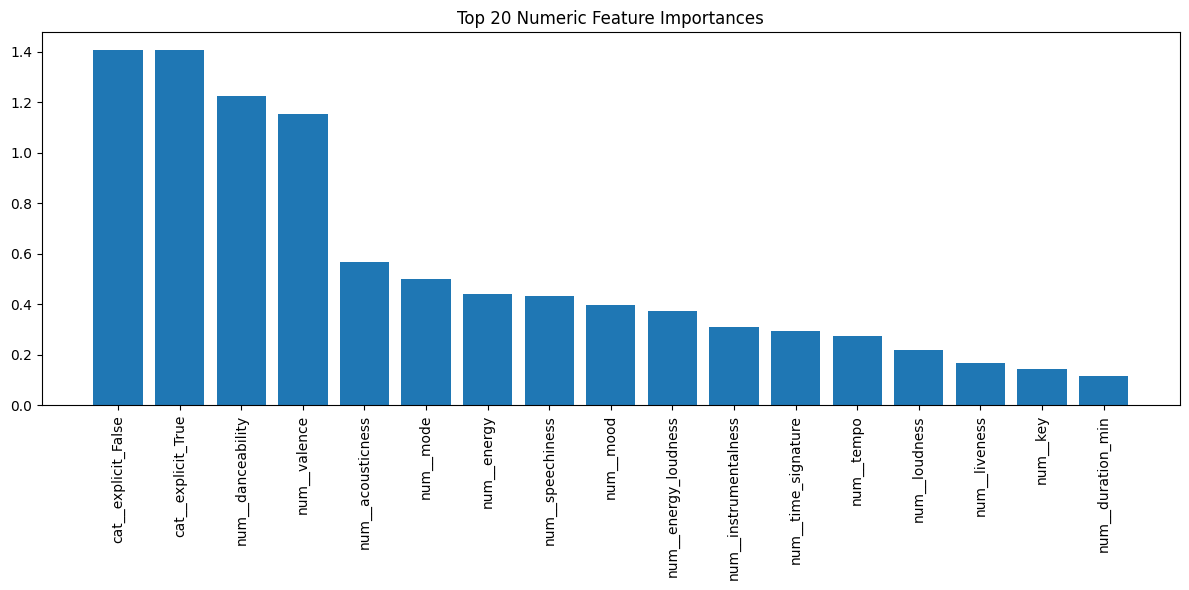

In [59]:
top_num = numeric_importance.head(20)

plt.figure(figsize=(12, 6))
plt.bar(top_num["feature"], top_num["abs_importance"])
plt.xticks(rotation=90)
plt.title("Top 20 Numeric Feature Importances")
plt.tight_layout()
plt.show()

Interpretation:
* Popularity is influenced more by overall vibe (danceability, valence, energy) than by technical music properties (tempo, key, duration).
* Explicit content and genre dominate, but once genres are removed, the model relies mainly on danceability, positivity, and acousticness.
* Many audio features contribute only weakly, explaining why the linear regression model achieves low R².

Top 20 genres from model

In [60]:
genre_importance = importance_df[
    importance_df["feature"].str.contains("track_genre")
]

genre_importance.head(20)

,feature,coefficient,abs_importance
76,cat__track_genre_iranian,-30.290585,30.290585
110,cat__track_genre_romance,-29.292669,29.292669
98,cat__track_genre_pop film,26.080463,26.080463
84,cat__track_genre_latin,-25.618654,25.618654
82,cat__track_genre_k pop,23.500136,23.500136
41,cat__track_genre_detroit techno,-22.307790,22.307790
30,cat__track_genre_chicago house,-21.257137,21.257137
81,cat__track_genre_jazz,-19.771757,19.771757
32,cat__track_genre_chill,19.198906,19.198906
83,cat__track_genre_kids,-18.414694,18.414694


Genres with Strong Negative Impact on Popularity.

These genres have large negative coefficients, meaning being in this genre reduces predicted popularity:
* iranian (strongest negative)
* romance
* pop film
* latin
* detroit techno
* chicago house
* jazz
* chill
* kids

These may have smaller listener bases or niche audience groups in the dataset, leading to lower average popularity.

Genres with large positive coefficients contribute to higher popularity predictions:
* k-pop (largest positive)
* sad
* indian
* country
* grunge
* sertanejo
* anime

These styles have broad, dedicated fanbases or strong cultural streaming support.

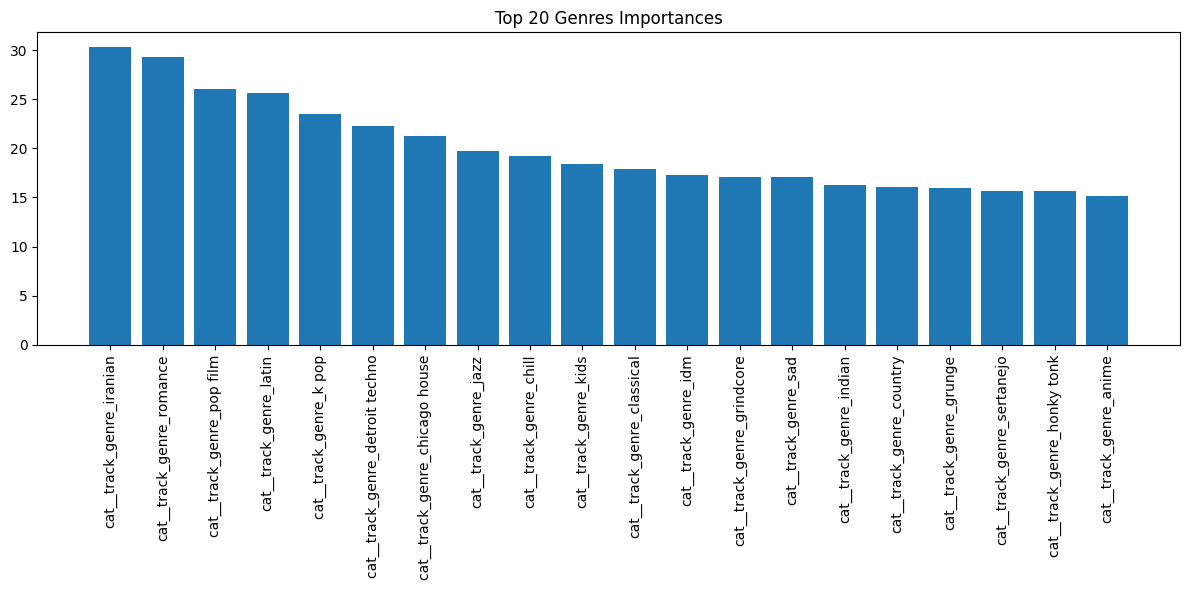

In [61]:
top_genres = genre_importance.head(20)

plt.figure(figsize=(12, 6))
plt.bar(top_genres["feature"], top_genres["abs_importance"])
plt.xticks(rotation=90)
plt.title("Top 20 Genres Importances")
plt.tight_layout()
plt.show()

Key insights:
* Genre is more important than audio features for predicting popularity in this dataset.
* The model is essentially learning each genre’s average popularity level.
* This is common in Linear Regression, because genre directly encodes who listens to the music, not just how it sounds.

Why Linear Regression behaves this way
* One-hot encoded genres act like labels for entire listener communities.
* Popularity varies drastically across communities (e.g., k-pop vs. techno).
* These differences produce much larger coefficients than scaled numeric features.

#### Conclusion

The linear regression baseline offers a transparent look at how each standardized feature impacts predicted popularity, making it ideal for initial diagnostics. However, any systematic under/over-prediction patterns or mediocre MAE/R^2 results highlight the need for richer models (tree ensembles, gradient boosting) and potentially more expressive feature engineering.

---

What to Do Next to Improve the Model
1. Switch from Linear Regression → Tree-based models
They outperform linear models for this dataset:
* RandomForestRegressor
* XGBoost
* GradientBoostingRegressor
* LightGBM

They capture nonlinear relationships.

2. Add powerful derived features
* Track age (release_year)
* Artist popularity
* Genre grouped into macro-genres
* Energy × Valence (mood)
* Loudness × Danceability

3. Remove low-variance or useless features
(key, mode, time_signature barely matter)

4. Try a classification approach
Predict popularity classes instead of exact numbers:
* 0–40 = low
* 41–70 = medium
* 71–100 = high
Classification performs better than regression on music data.

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Build Random Forest pipeline
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Train
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)

# Evaluate
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Results:")
print(f"MAE  : {rf_mae:.3f}")
print(f"RMSE : {rf_rmse:.3f}")
print(f"R^2  : {rf_r2:.3f}")


KeyboardInterrupt: 

In [ ]:
# Extract feature names
rf_features = rf_model.named_steps["preprocess"].get_feature_names_out()

# Extract importances
rf_importances = rf_model.named_steps["regressor"].feature_importances_

# Build df
rf_importance_df = pd.DataFrame({
    "feature": rf_features,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

# Show top 20
rf_importance_df.head(20)


In [ ]:
top_rf = rf_importance_df.head(20)

plt.figure(figsize=(12,6))
plt.bar(top_rf["feature"], top_rf["importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance (Top 20)")
plt.tight_layout()
plt.show()


In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

# Build XGBoost pipeline
xgb_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
xgb_pred = xgb_model.predict(X_test)

# Evaluate
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost Results:")
print(f"MAE  : {xgb_mae:.3f}")
print(f"RMSE : {xgb_rmse:.3f}")
print(f"R^2  : {xgb_r2:.3f}")


In [ ]:
# Extract transformed feature names
xgb_features = xgb_model.named_steps["preprocess"].get_feature_names_out()

# Extract feature importances
xgb_importances = xgb_model.named_steps["regressor"].feature_importances_

# Build df
xgb_importance_df = pd.DataFrame({
    "feature": xgb_features,
    "importance": xgb_importances
}).sort_values("importance", ascending=False)

# Show top 20
xgb_importance_df.head(20)


In [ ]:
top_xgb = xgb_importance_df.head(20)

plt.figure(figsize=(12,6))
plt.bar(top_xgb["feature"], top_xgb["importance"])
plt.xticks(rotation=90)
plt.title("XGBoost Feature Importance (Top 20)")
plt.tight_layout()
plt.show()
